In [2]:
"""
V4 incluye doblado con FFT y suavizado con Savizky-Golay (recomendable solo p/calibraciones de baja estadística)
El archivo ".mos" o ".Asc" de entrada no debe tener encabezado
Preparando para Colab e importando librerías necesarias.
"""
!pip install lmfit
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
img = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/INTECIN/Iguazu/Iguazu01.Asc'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lmfit import Parameters, minimize, fit_report
from scipy.constants import *
from scipy.integrate import trapz
from scipy.signal import savgol_filter
from pathlib import Path

path= Path(img); name= path.stem; title= path.parent.name; full= path.parents[0]; print(name, title, full)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00
Mounted at /content/drive/
Iguazu01 Iguazu /content/drive/MyDrive/Colab-Notebooks/PyMossFit/INTECIN/Iguazu


Ingrese la fecha de calibración (AAAAMMDD): 20241202
Ingrese el rango de V (en mm/s): -15.075


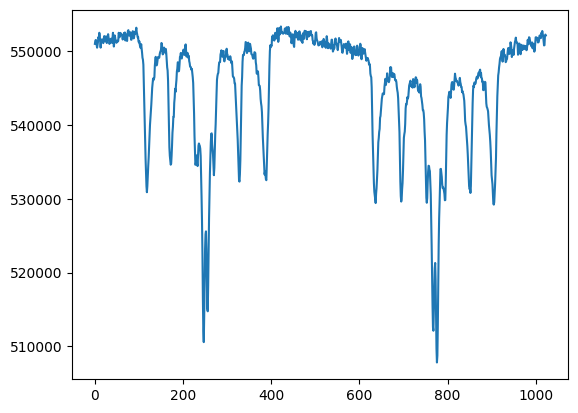

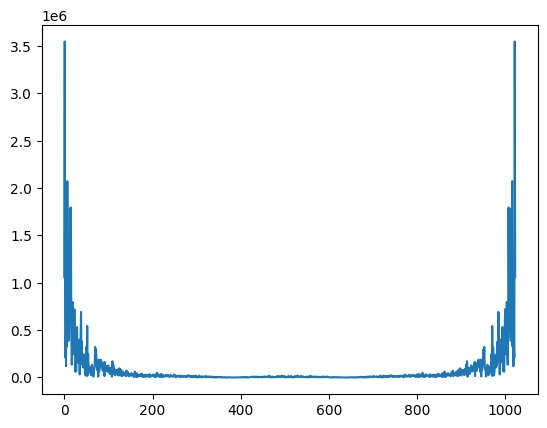

Media del fondo: 1102945
Canal de doblado: 515


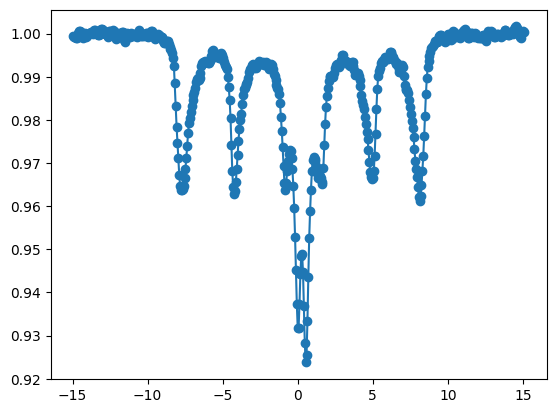

In [3]:
"""
Para doblar, normalizar y calibrar en mm/s, los archivos del espectrómetro de CNEA de 512 canales o de INTECIN de 1024
"""
y= np.loadtxt(img, delimiter=" "); y=y[:] #agregar delimiter="," o delimiter=" " en loadtxt si es de dos columnas. Caso contrario comentar y=y[:,1]
N=len(y); N2=int(N/2); N4=int(N/4)

fecha = str(input('Ingrese la fecha de calibración (AAAAMMDD): '),)
vel = float(input('Ingrese el rango de V (en mm/s): ' ), )
np.savetxt(f"{full}/{name}-calib.txt", (fecha,vel, N), fmt='%s')

#

y= savgol_filter(y, 5, 2) #solo si se trata de espectro con baja estadística, comentar en otro caso
plt.plot(y)
plt.show()

"""
Doblado con FFT (basado en el Nyquist-Shannon sampling theorem, https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter24.02-Discrete-Fourier-Transform.html)
"""
f= abs(np.fft.fft(y)); Nf=pd.Series(f[N2-5:N2+5]).idxmax()+(N2-5)
plt.plot(f[1:N])
plt.show()

for i in range(0, Nf-1):
    y[[i]]=y[[i]]+y[[N-1-i]]

y=y[0:N2-1]
"""
Normalización
"""
y2= np.concatenate([y[2:30],y[N2-30:N2-2]])

ymax=np.mean(y2)
ymax=int(ymax)

for i in range(0, N2-1):
    y[[i]]=y[[i]]/ymax

x=np.arange(1,N2)
y= savgol_filter(y, 5, 2)

"""
de canales a escala de velocidades en mm/s
"""
v=np.loadtxt(f"{full}/{name}-calib.txt"); vmax=v[[1]]

x=np.linspace(start = 0, stop = N2-1, num= N2)

for i in range(0, N2-1):
    x[[i]]=(i-N4)*vmax/N4

x= x[0:N2-1]

print('Media del fondo:', ymax); print('Canal de doblado:', Nf)

plt.plot(x,y, marker="o")
plt.show()

np.savetxt(f"{full}/{name}.csv", list(zip(x,y)), delimiter=",", fmt='%1.6f')

<ipython-input-4-bde18ddcf0a2>:105: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  int1= trapz(1-z1, x); int2= trapz(1-z2, x); int3= trapz(1-z3, x); int4= trapz(1-z4, x); int5= trapz(1-z5, x); total=int1+int2+int3+int4+int5


ancho1 (sigma1/sqrt(2)) es: 0.37 mm/s
Centroide1 (ISO1) es: 0.302 mm/s
Doblete1 es: 0.610 mm/s
área1: 26.3 %
ancho2 (sigma2/sqrt(2)) es: 0.47 mm/s
Centroide2 (ISO2) es: 0.500 mm/s
B2 (Campo) es: 44.1 T
área2: 11.5 %
ancho3 (sigma3/sqrt(2)) es: 0.54 mm/s
Centroide3 (ISO3) es: 0.249 mm/s
B3 (Campo) es: 49.0 T
área3: 52.3 %
ancho4 (sigma4/sqrt(2)) es: 0.29 mm/s
Centroide1 (ISO1) es: 0.322 mm/s
Doblete1 es: 2.210 mm/s
área4: 8.6 %
ancho5 (sigma5/sqrt(2)) es: 0.13 mm/s
Centroide5 (ISO5) es: 0.485 mm/s
área5: 1.3 %
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 709
    # data points      = 511
    # variables        = 21
    chi-square         = 0.00266414
    reduced chi-square = 5.4370e-06
    Akaike info crit   = -6173.92812
    Bayesian info crit = -6084.96436
[[Variables]]
    b1:    0.51931013 +/- 0.01996098 (3.84%) (init = 0.45)
    m1:    0.30206608 +/- 0.00552661 (1.83%) (init = 0.25)
    d1:    0.61 (fixed)
    a1:    0.04368392 +/- 0.00124360 (2

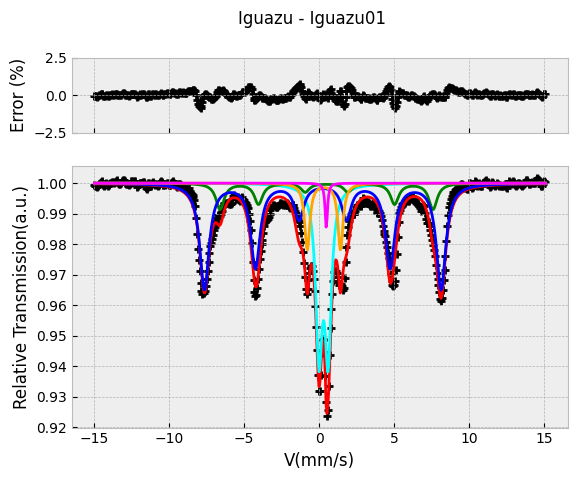

In [4]:
"""
LECTURA DE ARCHIVO DE ENTRADA
"""
col_list=[0, 1]

x, y= np.loadtxt(f"{full}/{name}.csv", delimiter=",", usecols=col_list, unpack=True)

"""
DEFINICIÓN DE LAS FUNCIONES BASADAS EN LORENTZIANAS y VOIGTIANAS
"""
def singlet(a, b, m, x):
    return 2*a*b/(pi*(b**2+4*(x-m)**2))

def doublet(a, b, m, d, x):
    return 2*a*b/(pi*(b**2+4*(x-(m-d/2))**2))+2*a*b/(pi*(b**2+4*(x-(m+d/2))**2))

def sextet(a, b, m, d, q, l23, x):
    return 3*a*b/(pi*(b**2+4*(x-(m+5*d))**2))+l23*a*b/(pi*(b**2+4*(x-(m+3*d-q))**2))+a*b/(pi*(b**2+4*(x-(m+d))**2))+a*b/(pi*(b**2+4*(x-(m-d))**2))+l23*a*b/(pi*(b**2+4*(x-(m-3*d+q))**2))+3*a*b/(pi*(b**2+4*(x-(m-5*d))**2))

def doublet_v(av, mv, bl, bg, dl, dg, x):
      return 2*av*bl/pi*(bl**2+(4*(x-(mv-dl/2))**2))+2*av*bl/pi*(bl**2+(4*(x-(mv+dl/2))**2))+(1-av)*np.exp(-(x-(mv-dg/2))**2/(2*bg**2))/(bg*np.sqrt(2*np.pi))+(1-av)*np.exp(-(x-(mv+dg/2))**2/(2*bg**2))/(bg*np.sqrt(2*np.pi))

def sextet_v(a, b, m, d, q, l23, x):
    return 3*a*(b/(pi*(b**2+4*(x-(m+5*d))**2))+np.exp(-(x-(m+5*d))**2/(2*b**2))/(b*np.sqrt(2*pi)))+l23 *a*(b/(pi*(b**2+4*(x-(m+3*d-q))**2))+np.exp(-(x-(m+3*d-q))**2/(2*b**2))/(b*np.sqrt(2*pi)))+a*(b/(pi*(b**2+4*(x-(m+d))**2))+np.exp(-(x-(m+d))**2/(2*b**2))/(b*np.sqrt(2*pi)))+a*(b/(pi*(b**2+4*(x-(m-d))**2))+np.exp(-(x-(m-d))**2/(2*b**2))/(b*np.sqrt(2*pi)))+l23*a*(b/(pi*(b**2+4*(x-(m-3*d+q))**2))+np.exp(-(x-(m-3*d+q))**2/(2*b**2))/(b*np.sqrt(2*pi)))+3*a*(b/(pi*(b**2+4*(x-(m-5*d))**2)+np.exp(-(x-(m-5*d))**2)/(2*b**2))/(b*np.sqrt(2*pi)))

def linear_fitting_lmfit(params, x, y):
    b1= params['b1']; m1= params['m1']; d1= params['d1']; a1= params['a1']
    a2= params['a2']; b2= params['b2']; m2= params['m2']; d2= params['d2']; q2= params['q2']; l232= params['l232']
    a3= params['a3']; b3= params['b3']; m3= params['m3']; d3= params['d3']; q3= params['q3']; l233= params['l233']
    a4= params['a4']; b4= params['b4']; m4= params['m4']; d4= params['d4']
    a5= params['a5']; b5= params['b5']; m5= params['m5']

    y_fit= 1-doublet(a1, b1, m1, d1, x)-sextet(a2, b2, m2, d2, q2, l232, x)-sextet(a3, b3, m3, d3, q3, l233, x)-doublet(a4, b4, m4, d4, x)-singlet(a5, b5, m5, x)

    return y_fit-y

"""
AJUSTE DE LOS PARÁMETROS USANDO LOS DATOS EXPERIMENTALES
"""
params= Parameters()

params.add('b1', value= 0.45, min= 0, max=0.55, vary=True)
params.add('m1', value= 0.25, min= 0.25, max=0.8, vary=True)
params.add('d1', value= 0.61, min= 0.1, max= 1.9, vary=False)
params.add('a1', value= 0.03, min= 0, vary=True)
params.add('a2', value= 0.06, min= 0, vary=True)
params.add('b2', value= 0.45, min= 0, max=1.0, vary=True)
params.add('m2', value= 0.55, vary=True)
params.add('d2', value= 1.5, min= 0.6, max= 2.5, vary=True)
params.add('q2', value= 0.15, vary=True)
params.add('l232', value= 2.4, vary=False)
params.add('a3', value= 0.18, min= 0, vary=True)
params.add('b3', value= 0.45, min= 0, max= 1.4, vary=True)
params.add('m3', value= 0.3, vary=True)
params.add('d3', value= 1.7, min= 0.8, max= 2, vary=True)
params.add('q3', value= 0.15, vary=True)
params.add('l233', value= 2.0, vary=True)
b4= params.add('b4', value= 0.75, min= 0.3, max=2.0, vary=True)
m4= params.add('m4', value= 0.35, vary=True)
d4= params.add('d4', value= 2.2, min= 0.1, max= 2.4, vary=True)
a4= params.add('a4', value= 0.03, min= 0, vary=True)
b5= params.add('b5', value= 0.25, min= 0, max=0.55, vary=True)
m5= params.add('m5', value= 0.25, min= 0.05, max=1.8, vary=True)
a5= params.add('a5', value= 0.008, min= 0, vary=True)

fitted_params= minimize(linear_fitting_lmfit, params, args=(x, y,), method='least_square')

m1= fitted_params.params['m1'].value
b1= fitted_params.params['b1'].value
d1= fitted_params.params['d1'].value
a1= fitted_params.params['a1'].value
a2= fitted_params.params['a2'].value
b2= fitted_params.params['b2'].value
m2= fitted_params.params['m2'].value
d2= fitted_params.params['d2'].value
q2= fitted_params.params['q2'].value
l232= fitted_params.params['l232'].value
a3= fitted_params.params['a3'].value
b3= fitted_params.params['b3'].value
m3= fitted_params.params['m3'].value
d3= fitted_params.params['d3'].value
q3= fitted_params.params['q3'].value
l233= fitted_params.params['l233'].value
a4= fitted_params.params['a4'].value
b4= fitted_params.params['b4'].value
m4= fitted_params.params['m4'].value
d4= fitted_params.params['d4'].value
a5= fitted_params.params['a5'].value
b5= fitted_params.params['b5'].value
m5= fitted_params.params['m5'].value
"""
CREACIÓN DE LOS SUBESPECTROS AJUSTADOS
"""
z= 1-(doublet(a1, b1, m1, d1, x))-(sextet(a2, b2, m2, d2, q2, l232, x))-(sextet(a3, b3, m3, d3, q3, l233, x))-doublet(a4, b4, m4, d4, x)-singlet(a5, b5, m5, x)
z1= 1-(doublet(a1, b1, m1, d1, x))
z2= 1-(sextet(a2, b2, m2, d2, q2, l232, x))
z3= 1-(sextet(a3, b3, m3, d3, q3, l233, x))
z4= 1-(doublet(a4, b4, m4, d4, x))
z5= 1-(singlet(a5, b5, m5, x))
e= (y-z)/y*100

"""
INTEGRAL DE ÁREAS Y GENERACIÓN DE LOS PARÁMETROS HIPERFINOS. REPORTE EN PANTALLA
"""
int1= trapz(1-z1, x); int2= trapz(1-z2, x); int3= trapz(1-z3, x); int4= trapz(1-z4, x); int5= trapz(1-z5, x); total=int1+int2+int3+int4+int5

b1= "{0:.2f}".format(b1/np.sqrt(2))
m1= "{0:.3f}".format(m1)
d1= "{0:.3f}".format(d1)
a1= "{0:.4f}".format(a1)
i1= "{0:.1f}".format(100*abs(int1/total))
a2= "{0:.4f}".format(a2)
b2= "{0:.2f}".format(b2/np.sqrt(2))
m2= "{0:.3f}".format(m2)
h2= "{0:.1f}".format(5*d2*33/5.312)
q2= "{0:.3f}".format(q2)
l232= "{0:.3f}".format(l232)
i2= "{0:.1f}".format(100*abs(int2/total))
a3= "{0:.4f}".format(a3)
b3= "{0:.2f}".format(b3/np.sqrt(2))
m3= "{0:.3f}".format(m3)
h3= "{0:.1f}".format(5*d3*33/5.312)
d3= "{0:.3f}".format(d3)
q3= "{0:.3f}".format(q3)
l233= "{0:.3f}".format(l233)
i3= "{0:.1f}".format(100*abs(int3/total))
a4= "{0:.4f}".format(a4)
b4= "{0:.2f}".format(b4/np.sqrt(2))
m4= "{0:.3f}".format(m4)
d4= "{0:.3f}".format(d4)
i4= "{0:.1f}".format(100*abs(int4/total))
a5= "{0:.4f}".format(a5)
b5= "{0:.2f}".format(b5/np.sqrt(2))
m5= "{0:.3f}".format(m5)
i5= "{0:.1f}".format(100*abs(int5/total))

print('ancho1 (sigma1/sqrt(2)) es:', b1, 'mm/s')
print('Centroide1 (ISO1) es:', m1, 'mm/s')
print('Doblete1 es:', d1, 'mm/s')
print('área1:', i1, '%')
print('ancho2 (sigma2/sqrt(2)) es:', b2, 'mm/s')
print('Centroide2 (ISO2) es:', m2, 'mm/s')
print('B2 (Campo) es:', h2, 'T')
print('área2:', i2, '%')
print('ancho3 (sigma3/sqrt(2)) es:', b3, 'mm/s')
print('Centroide3 (ISO3) es:', m3, 'mm/s')
print('B3 (Campo) es:', h3, 'T')
print('área3:', i3, '%')
print('ancho4 (sigma4/sqrt(2)) es:', b4, 'mm/s')
print('Centroide1 (ISO1) es:', m4, 'mm/s')
print('Doblete1 es:', d4, 'mm/s')
print('área4:', i4, '%')
print('ancho5 (sigma5/sqrt(2)) es:', b5, 'mm/s')
print('Centroide5 (ISO5) es:', m5, 'mm/s')
print('área5:', i5, '%')
print(fit_report(fitted_params))

"""
GRAFICA DE ESPECTROS Y SUBESPECTROS
"""
plt.style.use('bmh')

fig, (ax1, ax2) = plt.subplots(2, sharex=True, height_ratios=[1,3.5]); fig.suptitle(f"{title}" " - " f"{name}")
ax1.scatter (x, e, c= 'black', marker='+')
ax1.set_ylim(-2.5,2.5)
ax1.set_ylabel('Error (%)')

ax2.scatter (x, y, c= 'black', marker='+')
ax2.set_xlabel('V(mm/s)')
ax2.set_ylabel('Relative Transmission(a.u.)')
ax2.plot(x, z, c='red')
ax2.plot(x, z1, c='cyan')
ax2.plot(x, z2, c='green')
ax2.plot(x, z3, c='blue')
ax2.plot(x, z4, c='orange')
ax2.plot(x, z5, c='magenta')

plt.show()

"""
GENERACIÓN DE ARCHIVOS DE SALIDA: DATOS Y PARÁMETROS
"""
np.savetxt(f"{full}/{name}-plot.csv", list(zip(x,y, z, z1, z2, z3, z4, z5)), fmt='%1.6e')

df= pd.DataFrame ({'Ancho(mm/s)': [b1, b2, b3, b4, b5], 'IS (mm/s)': [m1, m2, m3, m4, m5], 'Quad Splitting (mm/s)': [d1, q2, q3, d4, 0], 'Bhf (T)': [0, h2, h3, 0, 0], 'Área(%)': [i1, i2, i3, i4, i5]})
df.to_csv(f"{full}/{name}-report.csv", index=False)

In [8]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# 1. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Cargar datos de referencia (base de datos)
reference_path = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/reference_data.csv'  # ¡Ajusta la ruta!
df_ref = pd.read_csv(reference_path)

# Función para convertir rangos a valores medios (ej: "0.37-0.45" → 0.41)
def parse_value(value):
    if isinstance(value, str) and '-' in value:
        min_val, max_val = map(float, value.split('-'))
        return (min_val + max_val) / 2
    return float(value)

# Procesar columnas relevantes
cols = ['IS (mm/s)', 'Quad Splitting (mm/s)', 'Bhf (T)']
for col in cols:
    df_ref[col] = df_ref[col].apply(parse_value)

# 3. Cargar datos experimentales
experimental_path = f"{full}/{name}-report.csv"  # ¡Ajusta la ruta!
df_exp = pd.read_csv(experimental_path)

# 4. Preprocesar datos experimentales (manejar NaN)
X_exp = df_exp[cols].fillna(0).values  # Si Bhf no existe, reemplazar NaN por 0

# 5. Entrenar modelo KNN
X_ref = df_ref[cols].values
model = NearestNeighbors(n_neighbors=3, metric='euclidean')
model.fit(X_ref)

# 6. Encontrar coincidencias
distances, indices = model.kneighbors(X_exp)

# 7. Mostrar resultados
for i, (dist, idx) in enumerate(zip(distances, indices)):
    print(f"\nMuestra experimental {i+1}:")
    for j, (d, pos) in enumerate(zip(dist, idx)):
        compound = df_ref.iloc[pos]['Compound Name']
        formula = df_ref.iloc[pos]['Chemical Formula']
        is_ref = df_ref.iloc[pos]['IS (mm/s)']
        qs_ref = df_ref.iloc[pos]['Quad Splitting (mm/s)']
        bhf_ref = df_ref.iloc[pos]['Bhf (T)']
        print(f"  Match {j+1}: {compound} ({formula})")
        print(f"    IS: {is_ref:.3f} mm/s | QS: {qs_ref:.3f} mm/s | Bhf: {bhf_ref:.1f} T")
        print(f"    Distancia euclidiana: {d:.2f}\n")

print("## Usar este resultado a modo orientativo. Se recomienda contar con información de la muestra en su composición y estructura ##")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Muestra experimental 1:
  Match 1: Pyrite (FeS₂)
    IS: 0.325 mm/s | QS: 0.625 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.03

  Match 2: Ferrihydrite (Fe₅HO₈·4H₂O)
    IS: 0.400 mm/s | QS: 0.600 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.10

  Match 3: Fe-MOFs (Fe₃O(BDC)₃)
    IS: 0.400 mm/s | QS: 0.600 mm/s | Bhf: 0.0 T
    Distancia euclidiana: 0.10


Muestra experimental 2:
  Match 1: Fe₃O₄ nanoparticles (Fe₃O₄)
    IS: 0.700 mm/s | QS: 0.000 mm/s | Bhf: 45.0 T
    Distancia euclidiana: 0.96

  Match 2: Magnetite (Fe₃O₄)
    IS: 0.670 mm/s | QS: 0.000 mm/s | Bhf: 46.0 T
    Distancia euclidiana: 1.93

  Match 3: Fe₃O₄ nanoparticles (Fe₃O₄)
    IS: 0.275 mm/s | QS: 0.000 mm/s | Bhf: 48.5 T
    Distancia euclidiana: 4.41


Muestra experimental 3:
  Match 1: Magnetite (Fe₃O₄)
    IS: 0.260 mm/s | QS: 0.000 mm/s | Bhf: 49.0 T
    Distancia euclidiana: 